In [59]:
# Factoring Data Analysis
# Import data from Kaggle using API
import os
import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files('hhenry/finance-factoring-ibm-late-payment-histories', path=os.path.join("datasets", "FactoringData"), unzip=True)

In [60]:
# Load saved data in pandas dataframe
import pandas as pd
data = pd.read_csv(os.path.join("datasets", "FactoringData","WA_Fn-UseC_-Accounts-Receivable.csv"))

In [61]:
# Get a glimpse of data
data.head()

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [62]:
# Check information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
countryCode      2466 non-null int64
customerID       2466 non-null object
PaperlessDate    2466 non-null object
invoiceNumber    2466 non-null int64
InvoiceDate      2466 non-null object
DueDate          2466 non-null object
InvoiceAmount    2466 non-null float64
Disputed         2466 non-null object
SettledDate      2466 non-null object
PaperlessBill    2466 non-null object
DaysToSettle     2466 non-null int64
DaysLate         2466 non-null int64
dtypes: float64(1), int64(4), object(7)
memory usage: 231.3+ KB


In [63]:
# Categories in countryCode
data['countryCode'].value_counts()

391    616
406    561
770    506
897    396
818    387
Name: countryCode, dtype: int64

In [64]:
# No. of different unique customers
data['customerID'].value_counts().count()

100

In [65]:
# Generate a new binary column whether it was late or not
data['Late'] = data.DaysLate.apply(lambda x: 1 if x>0 else 0)
data['Late'].value_counts()

0    1589
1     877
Name: Late, dtype: int64

In [66]:
# Converting all date columns to datetime format in pandas
import datetime
data['PaperlessDate']= pd.to_datetime(data.PaperlessDate)
data['InvoiceDate']= pd.to_datetime(data.InvoiceDate)
data['SettledDate']= pd.to_datetime(data.SettledDate)
data['DueDate']= pd.to_datetime(data.DueDate)

# Spliting into train and test set based on dates(As our goal is to check whether there will be a late payment?)
train_set = data[data['InvoiceDate'] < datetime.date(2013, 8, 1)] 
test_set = data[data['InvoiceDate'] >= datetime.date(2013, 8, 1)]

C:\Users\Abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  if __name__ == '__main__':
C:\Users\Abc\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  # Remove the CWD from sys.path while we load stuff.


In [67]:
# Assign train_set to data
data = train_set
# Assigning count to count total orders placed by customers and country
data['count'] = 1
# Calculate Probability of Customers Late Payment
Y = data.groupby(data.customerID).sum()
Y['ProbLatePaymentByCust'] = Y['Late']/Y['count']
Y = Y.drop(['countryCode','invoiceNumber','InvoiceAmount','DaysToSettle', 'DaysLate','Late','count'], axis=1)
Y.head()

,ProbLatePaymentByCust
customerID,
0187-ERLSR,0.000000
0379-NEVHP,0.047619
0465-DTULQ,0.608696
0625-TNJFG,0.181818
0688-XNJRO,0.960000


In [68]:
# Assigning new to count total orders placed by countries/ Total Orders by the customers of the country
Z = data.groupby(data.countryCode).sum()
Z['ProbLatePaymentByCountry'] = Z['Late']/Z['count']
Z = Z.drop(['invoiceNumber','InvoiceAmount','DaysToSettle', 'DaysLate','Late','count'], axis=1)
Z.head()

,ProbLatePaymentByCountry
countryCode,
391,0.263889
406,0.441860
770,0.427518
818,0.414110
897,0.327217


In [69]:
# Pipelien to apply transformations to data
def pipeline_1(df, Y, Z):
    df = df.set_index('customerID').join(Y)
    df['customerID'] = df.index
    df = df.set_index('countryCode').join(Z)
    df['countryCode'] = df.index
    df['Disputed'] = df['Disputed'].map({'No':0,'Yes':1})
    df['PaperlessBill'] = df['PaperlessBill'].map({'Paper': 0,'Electronic': 1})
    df = df.fillna(0)
    df = df.drop(['PaperlessDate','invoiceNumber','DueDate','SettledDate','DaysToSettle','DaysLate','customerID','countryCode'], axis=1)
    return df

data = data.drop(['count'], axis=1)
data = pipeline_1(data, Y, Z)
data.head()

,InvoiceDate,InvoiceAmount,Disputed,PaperlessBill,Late,ProbLatePaymentByCust,ProbLatePaymentByCountry
countryCode,,,,,,,
391,2012-09-05,84.57,0,0,0,0.0,0.263889
391,2012-03-29,62.68,1,0,0,0.0,0.263889
391,2012-09-22,65.26,1,0,0,0.0,0.263889
391,2013-02-16,56.50,1,0,0,0.0,0.263889
391,2013-03-22,86.92,0,0,0,0.0,0.263889


In [70]:
corr_matrix = data.corr()
corr_matrix["Late"].sort_values(ascending=False)

Late                        1.000000
ProbLatePaymentByCust       0.702452
Disputed                    0.377497
ProbLatePaymentByCountry    0.149853
InvoiceAmount               0.065159
PaperlessBill              -0.144638
Name: Late, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022E5BB62278>,
      dtype=object)

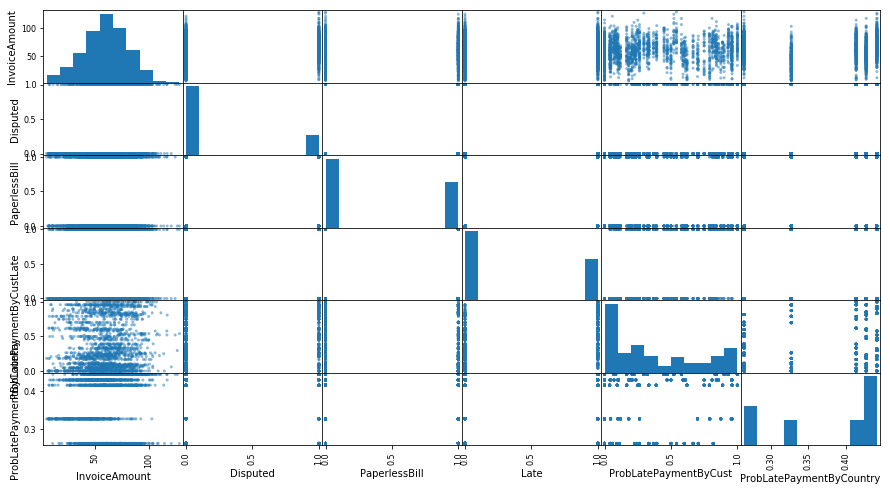

In [71]:
from pandas.plotting import scatter_matrix

scatter_matrix(data, figsize=(15,8))

In [72]:
# Creating an dataframe with all dates between start and stop
import pandas as pd
import numpy as np
start = '2011-11-01'
stop = '2014-01-01'
macro_variables = pd.date_range(start, stop)

macro_variables = pd.DataFrame(macro_variables)
macro_variables = macro_variables.rename(columns = {0:'DATE'})

In [73]:
# Importing Macro-variables in pandas dataframe
unemployment = pd.read_csv(os.path.join("datasets", "ICSA.csv"))
unemployment['DATE']= pd.to_datetime(unemployment.DATE)                  #Converting to pandas datetime format
macro_prod = pd.read_csv(os.path.join("datasets", "INDPRO.csv"))
macro_prod['DATE']= pd.to_datetime(macro_prod.DATE)                      #Converting to pandas datetime format
infla_rate = pd.read_csv(os.path.join("datasets", "PPIACO.csv"))
infla_rate['DATE']= pd.to_datetime(infla_rate.DATE)                      #Converting to pandas datetime format

#Combining macrodata into one dataframe
macro_variables = macro_variables.set_index('DATE').join(unemployment.set_index('DATE'))
macro_variables = macro_variables.join(macro_prod.set_index('DATE'))
macro_variables = macro_variables.join(infla_rate.set_index('DATE'))

macro_variables.ffill(axis=0, inplace=True)  #Forward Filling blank Values

macro_variables = macro_variables.pct_change()  #Calculating percentage change compared to previous release of data
macro_variables.replace(0.00, np.nan, inplace=True)
macro_variables = macro_variables.ffill(axis=0) #Forward Filling blank Values

#macro_variables = macro_variables.reset_index() #Rest index back to normal from dates
macro_variables.head()

,ICSA,INDPRO,PPIACO
DATE,,,
2011-11-01,NaN,NaN,NaN
2011-11-02,NaN,NaN,NaN
2011-11-03,NaN,NaN,NaN
2011-11-04,NaN,NaN,NaN
2011-11-05,NaN,NaN,NaN


In [74]:
# pipeline to join macro-variables to test data
def pipeline_2(df, macro_variables):
    df = df.set_index('InvoiceDate').join(macro_variables)
    return df

data = pipeline_2(data, macro_variables)
data.head()

,InvoiceAmount,Disputed,PaperlessBill,Late,ProbLatePaymentByCust,ProbLatePaymentByCountry,ICSA,INDPRO,PPIACO
2012-01-03,55.37,0,0,1,0.818182,0.263889,-0.025907,0.006123,0.004505
2012-01-03,71.33,0,0,0,0.296296,0.441860,-0.025907,0.006123,0.004505
2012-01-03,50.39,0,0,0,0.000000,0.427518,-0.025907,0.006123,0.004505
2012-01-03,97.60,0,0,1,1.000000,0.414110,-0.025907,0.006123,0.004505
2012-01-03,15.99,1,0,1,0.620690,0.414110,-0.025907,0.006123,0.004505


In [75]:
corr_matrix = data.corr()
corr_matrix["Late"].sort_values(ascending=False)

Late                        1.000000
ProbLatePaymentByCust       0.702452
Disputed                    0.377497
ProbLatePaymentByCountry    0.149853
InvoiceAmount               0.065159
INDPRO                      0.030707
PPIACO                     -0.001318
ICSA                       -0.018722
PaperlessBill              -0.144638
Name: Late, dtype: float64

In [76]:
# Labeling for feeding to the model
def pipeline_3(df):
    df = df.drop(['InvoiceAmount','PaperlessBill'], axis=1)
    return df

data = pipeline_3(data)

X = data.drop(['Late'],axis=1)
y = data['Late'].copy()

In [77]:
# Applying Logistic Regression
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=69)
log_clf.fit(X,y)

C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=69, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [78]:
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(log_clf, X, y, cv=4, scoring="accuracy")
precision = cross_val_score(log_clf, X, y, cv=4, scoring="precision")
recall = cross_val_score(log_clf, X, y, cv=4, scoring="recall")

def Average(lst): 
    return sum(lst) / len(lst) 

accuracy = Average(accuracy)
precision = Average(precision)
recall = Average(recall)

print('Average accuracy using log_clf:', round(accuracy,2))
print('Average precision using log_clf:', round(precision,2))
print('Average recall using log_clf:', round(recall,2))

C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

Average accuracy using log_clf: 0.86
Average precision using log_clf: 0.83
Average recall using log_clf: 0.79


In [79]:
# Applying Support Vector Machine
from sklearn.svm import LinearSVC
linear_svc_clf = LinearSVC(C=1, loss='hinge',random_state=69)
linear_svc_clf.fit(X, y)

C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=69, tol=0.0001, verbose=0)

In [80]:
accuracy = cross_val_score(linear_svc_clf, X, y, cv=4, scoring="accuracy")
precision = cross_val_score(linear_svc_clf, X, y, cv=4, scoring="precision")
recall = cross_val_score(linear_svc_clf, X, y, cv=4, scoring="recall")

accuracy = Average(accuracy)
precision = Average(precision)
recall = Average(recall)

print('Average accuracy using linear_svc_clf:', round(accuracy,2))
print('Average precision using linear_svc_clf:', round(precision,2))
print('Average recall using linear_svc_clf:', round(recall,2))

C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Convergenc

Average accuracy using linear_svc_clf: 0.86
Average precision using linear_svc_clf: 0.81
Average recall using linear_svc_clf: 0.81


In [81]:
# Applying Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=69)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=69,
            splitter='best')

In [82]:
accuracy = cross_val_score(tree_clf, X, y, cv=4, scoring="accuracy")
precision = cross_val_score(tree_clf, X, y, cv=4, scoring="precision")
recall = cross_val_score(tree_clf, X, y, cv=4, scoring="recall")

accuracy = Average(accuracy)
precision = Average(precision)
recall = Average(recall)

print('Average accuracy using tree_clf:', round(accuracy,2))
print('Average precision using tree_clf:', round(precision,2))
print('Average recall using tree_clf:', round(recall,2))

Average accuracy using tree_clf: 0.86
Average precision using tree_clf: 0.81
Average recall using tree_clf: 0.81


In [83]:
# Applying Voting Classifier
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('svc', linear_svc_clf), ('rf', tree_clf)],
            voting='hard'
            )
voting_clf.fit(X, y)

C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=69, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('svc', LinearSVC...        min_weight_fraction_leaf=0.0, presort=False, random_state=69,
            splitter='best'))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [84]:
accuracy = cross_val_score(voting_clf, X, y, cv=4, scoring="accuracy")
precision = cross_val_score(voting_clf, X, y, cv=4, scoring="precision")
recall = cross_val_score(voting_clf, X, y, cv=4, scoring="recall")

accuracy = Average(accuracy)
precision = Average(precision)
recall = Average(recall)

print('Average accuracy using voting_clf:', round(accuracy,2))
print('Average precision using voting_clf:', round(precision,2))
print('Average recall using voting_clf:', round(recall,2))

C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Abc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
 

Average accuracy using voting_clf: 0.86
Average precision using voting_clf: 0.82
Average recall using voting_clf: 0.8


In [85]:
# Applying AdaBoost
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3), n_estimators=100,
        algorithm="SAMME.R", learning_rate=0.5, random_state=69
        )
ada_clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=100, random_state=69)

In [86]:
accuracy = cross_val_score(ada_clf, X, y, cv=4, scoring="accuracy")
precision = cross_val_score(ada_clf, X, y, cv=4, scoring="precision")
recall = cross_val_score(ada_clf, X, y, cv=4, scoring="recall")

accuracy = Average(accuracy)
precision = Average(precision)
recall = Average(recall)

print('Average accuracy using ada_clf:', round(accuracy,2))
print('Average precision using ada_clf:', round(precision,2))
print('Average recall using ada_clf:', round(recall,2))

Average accuracy using ada_clf: 0.75
Average precision using ada_clf: 0.66
Average recall using ada_clf: 0.7


In [87]:
# Converting to full pipeline to apply to test_set
def full_pipeline(df, Y, Z, macro_variables):
    phase_1 = pipeline_1(df, Y, Z)
    phase_2 = pipeline_2(phase_1, macro_variables)
    phase_3 = pipeline_3(phase_2)
    return phase_3

test = full_pipeline(test_set, Y, Z, macro_variables)

In [111]:
X = test.drop(['Late'],axis=1)
y = test['Late'].copy()
X.head()

,Disputed,ProbLatePaymentByCust,ProbLatePaymentByCountry,ICSA,INDPRO,PPIACO
2013-08-01,1,0.238095,0.263889,-0.059155,0.006603,-0.000978
2013-08-01,0,0.956522,0.427518,-0.059155,0.006603,-0.000978
2013-08-01,0,0.000000,0.414110,-0.059155,0.006603,-0.000978
2013-08-01,0,0.333333,0.414110,-0.059155,0.006603,-0.000978
2013-08-03,0,0.705882,0.263889,0.014970,0.006603,-0.000978


In [124]:
result = tree_clf.predict(X)

In [128]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
precision_score(result, y)

0.7563025210084033

In [129]:
recall_score(result, y)

0.656934306569343

In [130]:
accuracy_score(result, y)

0.8228438228438228